# 📊 Proyecto de Auditoría: Optimización de Activos Fijos y Detección de Obsolescencia

**Autor:** Octavio Landa Verde
**Objetivo:** No basta con tener un inventario; necesitamos saber cuánto valen realmente nuestros activos hoy. En este notebook, voy a auditar una base de datos real (anonimizada) de más de 40000 bienes para detectar cuáles ya cumplieron su vida útil y representan un riesgo financiero oculto.

¡Vamos a darle sentido a estos datos! 🚀

In [18]:
# Primero, traigo toda la artillería pesada.
# Pandas para manipular las tablas y Seaborn para que las gráficas se vean decentes.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configuro el estilo visual para que no se vea como gráfico de Excel de los 90s jijiji...
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

print("✅ Librerías listas. ¡A trabajar!")

✅ Librerías listas. ¡A trabajar!


## 1. Carga de Datos y Exploración Inicial
Lo primero es meter los datos al sistema. Como a veces los archivos de gobierno vienen en formatos antiguos (.xls) o nuevos (.xlsx), preparé un pequeño script que intenta leer ambos para no pelearme con el formato.

In [19]:
# Nombre base del archivo
archivo = 'activos_anonimos.xls'

try:
    # Intento leerlo tal cual
    df = pd.read_excel(archivo)
    print(f"✅ Archivo '{archivo}' cargado correctamente.")
except:
    try:
        # Si falla, pruebo agregándole la 'x' de la versión moderna
        df = pd.read_excel(archivo + 'x')
        print(f"✅ Archivo '{archivo}x' cargado correctamente.")
    except Exception as e:
        print(f"❌ Houston, tenemos un problema: {e}")

# Vamos a echar un vistazo rápido a lo que tenemos
print(f"\nDimensiones del dataset: {df.shape[0]} filas y {df.shape[1]} columnas.")
display(df.head(3))

✅ Archivo 'activos_anonimos.xls' cargado correctamente.

Dimensiones del dataset: 48519 filas y 22 columnas.


,Clase,Tipo,Comple. Desc.,ID Artículo,Descr. Artículo,Nombre Fabricante,ID Serie,Modelo,Categoría,Comentario NNI,...,Combinación,Ubicación,S R,Costo,Fecha_Adquisición,No Alta,Contrato,F. Ultmo. Mov.,Tipo resguardo,Num. Usuarios
0,1185006,Múdulo De Atención Y Orientación Al Derechohab...,Al Derechohabiente Tipo A,NaN,NaN,Industrias Riviera,Sin Serie,Modulo,MADM,NaN,...,UI_CC VALIDA,31020001,21,71837.64,2012-07-24,T90135,11bi150,2016-06-13,Uso Colectivo y Compartido,6
1,2084008,Computadora/Microcomputadora,Equip.Computo Proc.Core17 4mg,NaN,NaN,Dell,C6tbnd2,Optiplex 7440,COMPU,NaN,...,UI_CC VALIDA,31020001,30,18989.20,2016-12-29,010188,0000011419,2024-12-20,Uso Colectivo y Compartido,6
2,5111,Mobiliario De Administración,Silla Semiejecutiva. Caracteri,20744.0,Silla Semiejecutiva. Caracteristicas Generales...,Pm Steele,Sin Serie,Especial,MADM,NaN,...,UI_CC VALIDA,31020001,21,3378.23,2018-10-15,0000015812,18bi0022,2024-12-20,Uso Colectivo y Compartido,6


### 🧐 Observaciones Iniciales (EDA Defensivo)
Al ver las primeras filas, noto un par de cosas que podrían romper el análisis si no las arreglo:
1.  **Fechas:** La columna `F. Adquisición` es clave, pero necesito asegurarme de que Python la entienda como fecha y no como texto.
2.  **Dinero:** La columna `Costo` a veces trae signos de pesos (`$`) o comas. Si no limpio eso, no podré hacer sumas ni restas.
3.  **Categorías:** Voy a usar la columna `Clase` para agrupar los bienes, ya que parece ser la más estandarizada.

In [20]:
# 1. Carga de nuevo para asegurar
archivo = 'activos_anonimos.xls'
try:
    df = pd.read_excel(archivo)
except:
    df = pd.read_excel(archivo + 'x')

# --- TRUCO DE MAGIA: Limpiar nombres de columnas ---
# Esto elimina espacios al inicio y final de cada nombre de columna
df.columns = df.columns.str.strip()

print("Nombres de columnas limpios:", df.columns.tolist())

# Ahora sí, definimos las columnas (asegúrate que coincidan con la lista que se imprima arriba)
# Si en la lista de arriba ves algo diferente, ajústalo aquí.
col_fecha = 'Fecha_Adquisición'
col_costo = 'Costo'
col_tipo = 'Clase'

print("\n🔧 Iniciando limpieza de datos...")

# 1. Limpieza de FECHAS
df[col_fecha] = pd.to_datetime(df[col_fecha], errors='coerce')

# 2. Limpieza de COSTOS
# Si Python leyó el costo como texto (Object), le quito los símbolos raros.
if df[col_costo].dtype == 'O':
    df[col_costo] = df[col_costo].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)
    df[col_costo] = pd.to_numeric(df[col_costo])

# Verifico que no hayan quedado nulos en las fechas
nulos_fecha = df[col_fecha].isnull().sum()
if nulos_fecha > 0:
    print(f"⚠️ Ojo: Hay {nulos_fecha} bienes sin fecha válida. Se excluirán del cálculo de antigüedad.")
    df = df.dropna(subset=[col_fecha])

print("✨ ¡Datos limpios y listos! Error superado.")
display(df.head(3))

Nombres de columnas limpios: ['Clase', 'Tipo', 'Comple. Desc.', 'ID Artículo', 'Descr. Artículo', 'Nombre Fabricante', 'ID Serie', 'Modelo', 'Categoría', 'Comentario NNI', 'UI. Estado', 'CC. Estado', 'Combinación', 'Ubicación', 'S R', 'Costo', 'Fecha_Adquisición', 'No Alta', 'Contrato', 'F. Ultmo. Mov.', 'Tipo resguardo', 'Num. Usuarios']

🔧 Iniciando limpieza de datos...
✨ ¡Datos limpios y listos! Error superado.


,Clase,Tipo,Comple. Desc.,ID Artículo,Descr. Artículo,Nombre Fabricante,ID Serie,Modelo,Categoría,Comentario NNI,...,Combinación,Ubicación,S R,Costo,Fecha_Adquisición,No Alta,Contrato,F. Ultmo. Mov.,Tipo resguardo,Num. Usuarios
0,1185006,Múdulo De Atención Y Orientación Al Derechohab...,Al Derechohabiente Tipo A,NaN,NaN,Industrias Riviera,Sin Serie,Modulo,MADM,NaN,...,UI_CC VALIDA,31020001,21,71837.64,2012-07-24,T90135,11bi150,2016-06-13,Uso Colectivo y Compartido,6
1,2084008,Computadora/Microcomputadora,Equip.Computo Proc.Core17 4mg,NaN,NaN,Dell,C6tbnd2,Optiplex 7440,COMPU,NaN,...,UI_CC VALIDA,31020001,30,18989.20,2016-12-29,010188,0000011419,2024-12-20,Uso Colectivo y Compartido,6
2,5111,Mobiliario De Administración,Silla Semiejecutiva. Caracteri,20744.0,Silla Semiejecutiva. Caracteristicas Generales...,Pm Steele,Sin Serie,Especial,MADM,NaN,...,UI_CC VALIDA,31020001,21,3378.23,2018-10-15,0000015812,18bi0022,2024-12-20,Uso Colectivo y Compartido,6


## 2. Ingeniería de Características: La Lógica Contable 🧮
Ya tenemos los datos limpios. Ahora voy a aplicar reglas de negocio para determinar si un bien sigue siendo útil contablemente o si ya es una pérdida.

Voy a crear una función que asigne la **Vida Útil** automáticamente según la descripción del bien (Clase):
* *Cómputo/Electrónica:* 3 años (se deprecian rápido).
* *Vehículos:* 5 años.
* *Mobiliario/Maquinaria:* 10 años (estándar).

Con esto, calcularé la **Depreciación Acumulada** real al día de hoy.

In [21]:
from datetime import datetime

# 1. Calcular Antigüedad en Años
# Restamos la fecha de hoy menos la de adquisición y convertimos los días a años
fecha_corte = datetime.now()
df['Antiguedad_Anios'] = (fecha_corte - df[col_fecha]).dt.days / 365.25

# 2. Asignar Vida Útil (Regla de Negocio)
# Esta función lee la columna "Clase" y decide cuántos años debería durar el bien
def asignar_vida_util(texto):
    texto = str(texto).lower()
    if 'cómputo' in texto or 'computo' in texto or 'electrónico' in texto or 'cpu' in texto or 'laptop' in texto:
        return 3
    if 'vehículo' in texto or 'transporte' in texto or 'camioneta' in texto:
        return 5
    # Para todo lo demás (Mobiliario, Equipo médico, Maquinaria), asumimos 10 años
    return 10

df['Vida_Util_Norma'] = df[col_tipo].apply(asignar_vida_util)

# 3. Calcular Depreciación y Valor en Libros
# Fórmula de Línea Recta: (Costo / Vida Útil) * Años que han pasado
df['Depreciacion_Acumulada'] = (df[col_costo] / df['Vida_Util_Norma']) * df['Antiguedad_Anios']

# ¡Ojo aquí! Un bien no se puede depreciar más de lo que costó originalmente.
# Si la depreciación calculada es mayor al costo, la topeamos al costo (valor residual 0).
df['Depreciacion_Acumulada'] = df[['Depreciacion_Acumulada', col_costo]].min(axis=1)

# Valor en Libros Actual (Net Book Value): Lo que vale hoy en libros contables
df['Valor_Libros_Actual'] = df[col_costo] - df['Depreciacion_Acumulada']

# Mostramos una muestra para ver que las matemáticas funcionaron
display(df[[col_tipo, col_costo, 'Antiguedad_Anios', 'Vida_Util_Norma', 'Valor_Libros_Actual']].head())

,Clase,Costo,Antiguedad_Anios,Vida_Util_Norma,Valor_Libros_Actual
0,1185006,71837.64,13.393566,10,0.000000
1,2084008,18989.20,8.960986,10,1973.005175
2,5111,3378.23,7.167693,10,956.818326
3,5151,21510.48,2.006845,10,17193.660879
4,5151,22915.67,1.010267,10,20600.575618


## 3. Auditoría de Riesgos (El Semáforo) 🚦
Esta es la parte crítica del proyecto. Voy a etiquetar cada activo con un "Semáforo":
* **CRÍTICO:** Si su antigüedad ya superó su vida útil normativa. Estos bienes valen $0 en libros y deberían ser evaluados para baja o sustitución.
* **OPERATIVO:** Bienes que aún tienen vida útil y valor financiero.

In [22]:
# Creamos la etiqueta de auditoría usando numpy (np.where es como un IF de Excel)
import numpy as np

df['Estado_Auditoria'] = np.where(df['Antiguedad_Anios'] >= df['Vida_Util_Norma'],
                                  'CRÍTICO: Vida Útil Excedida',
                                  'OPERATIVO: Vigente')

# Contamos cuántos cayeron en cada categoría para tener un primer vistazo
conteo_estado = df['Estado_Auditoria'].value_counts()

print("--- Resumen Preliminar de la Auditoría ---")
print(conteo_estado)

--- Resumen Preliminar de la Auditoría ---
Estado_Auditoria
CRÍTICO: Vida Útil Excedida    29656
OPERATIVO: Vigente             18863
Name: count, dtype: int64


## 4. Visualización de Resultados y Reporte Ejecutivo 📉
Para finalizar, voy a generar un gráfico de impacto que muestre qué categorías (Clases) tienen el mayor problema de obsolescencia. Esto es lo que se presentaría a una dirección financiera para justificar presupuesto de renovación.

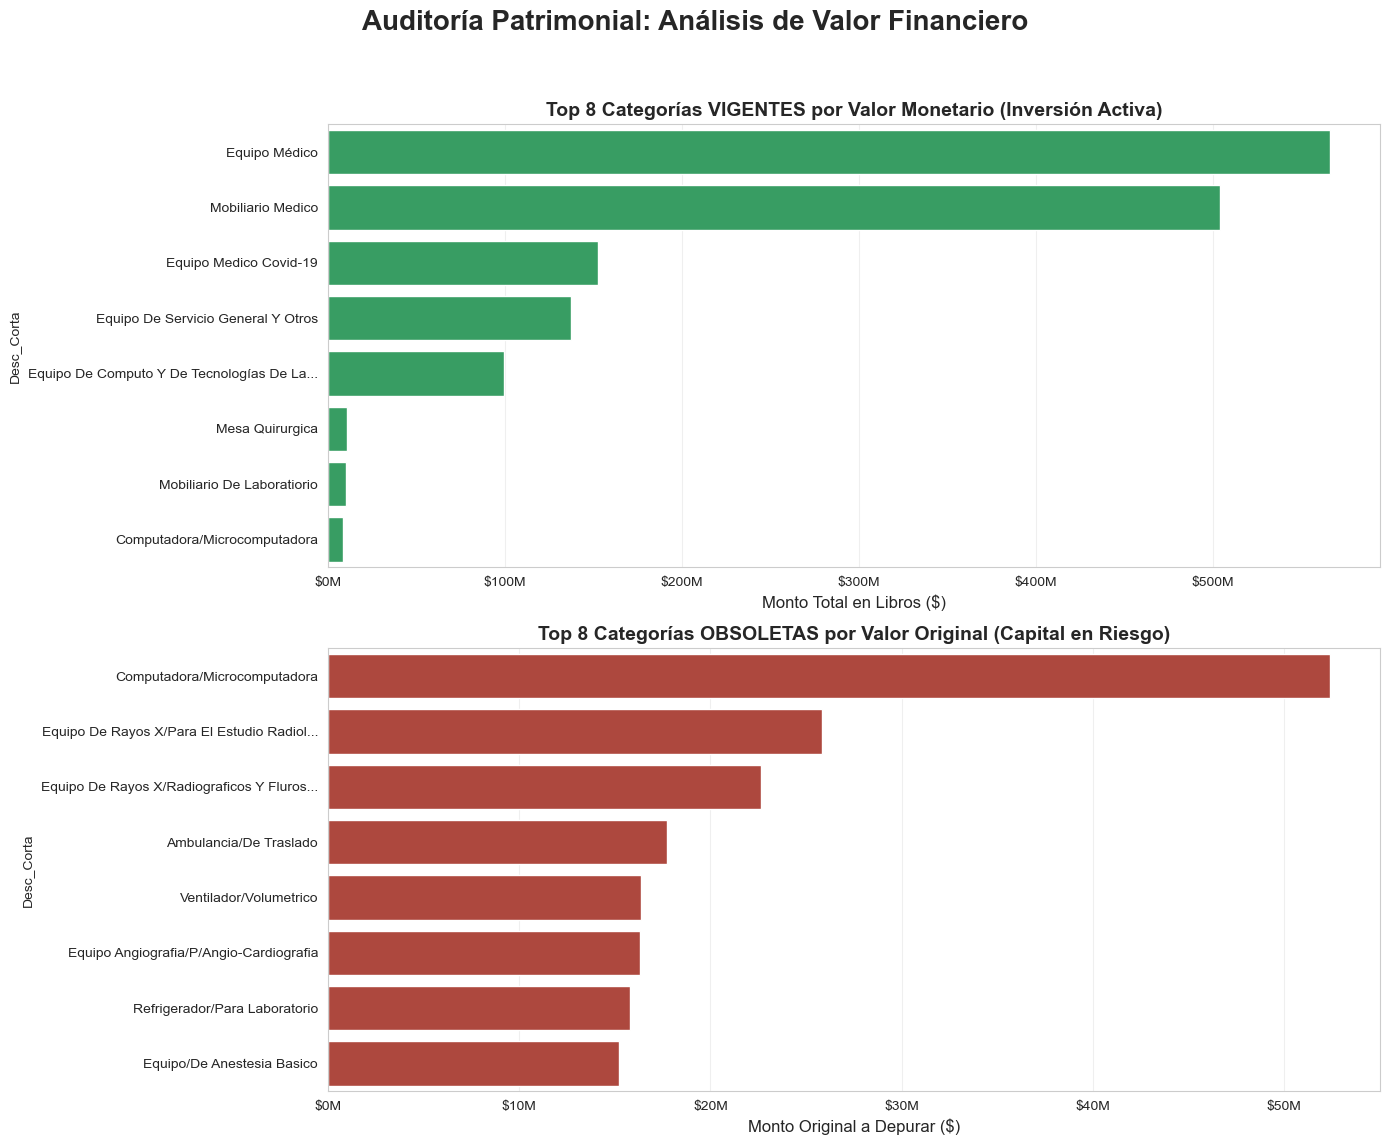


--- 💰 RESUMEN DEL DINERO ---
✅ Valor Activo (Vigente):  $1,615,091,762.79
❌ Valor en Riesgo (Obs):   $671,519,523.99
📉 Ratio de Obsolescencia:  Por cada $1.00 invertido, $0.29 ya son obsoletos.


In [27]:
# --- 4. DASHBOARD FINANCIERO DE ALTO NIVEL (Columna TIPO) ---
import matplotlib.ticker as ticker

# La columna 'Tipo' está completa
col_descripcion = 'Tipo' 

# 1. LIMPIEZA Y PREPARACIÓN
# Rellenamos nulos por seguridad
df[col_descripcion] = df[col_descripcion].fillna('SIN CLASIFICACIÓN')

# Cortamos el texto a 40 caracteres para que la gráfica no se deforme
df['Desc_Corta'] = df[col_descripcion].astype(str).apply(lambda x: x[:40] + '...' if len(x) > 40 else x)

# 2. SEPARACIÓN DE DATOS
df_vigente = df[df['Estado_Auditoria'] == 'OPERATIVO: Vigente']
df_critico = df[df['Estado_Auditoria'] == 'CRÍTICO: Vida Útil Excedida']

# 3. CONFIGURACIÓN DEL LIENZO
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
fig.suptitle('Auditoría Patrimonial: Análisis de Valor Financiero', fontsize=20, fontweight='bold')

# --- GRÁFICA 1: ACTIVOS VIGENTES (Verde) ---
# Sumamos el COSTO por Tipo de bien
top_vigente = df_vigente.groupby('Desc_Corta')[col_costo].sum().nlargest(8).sort_values(ascending=False)

sns.barplot(x=top_vigente.values, y=top_vigente.index, ax=ax1, color='#27AE60')
ax1.set_title('Top 8 Categorías VIGENTES por Valor Monetario (Inversión Activa)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Monto Total en Libros ($)', fontsize=12)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '${:,.0f}M'.format(x/1000000))) # Millones
ax1.grid(axis='x', alpha=0.3)

# --- GRÁFICA 2: ACTIVOS OBSOLETOS (Rojo) ---
top_critico = df_critico.groupby('Desc_Corta')[col_costo].sum().nlargest(8).sort_values(ascending=False)

sns.barplot(x=top_critico.values, y=top_critico.index, ax=ax2, color='#C0392B')
ax2.set_title('Top 8 Categorías OBSOLETAS por Valor Original (Capital en Riesgo)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Monto Original a Depurar ($)', fontsize=12)
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '${:,.0f}M'.format(x/1000000))) # Millones
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('dashboard_auditoria_financiera.png', dpi=300)
plt.show()

# --- KPI FINANCIERO FINAL ---
total_dinero_vigente = df_vigente[col_costo].sum()
total_dinero_critico = df_critico[col_costo].sum()

print(f"\n--- 💰 RESUMEN DEL DINERO ---")
print(f"✅ Valor Activo (Vigente):  ${total_dinero_vigente:,.2f}")
print(f"❌ Valor en Riesgo (Obs):   ${total_dinero_critico:,.2f}")
print(f"📉 Ratio de Obsolescencia:  Por cada $1.00 invertido, ${total_dinero_critico/(total_dinero_vigente+total_dinero_critico):.2f} ya son obsoletos.")